## Generalization 

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(3*'../')

import os
import glob
from pathlib import Path
from omegaconf import DictConfig
import yaml
import pickle
from collections import defaultdict


import torch
import lightning as L

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.utils.lightning import load_model_from_checkpoint, clean_hydra_config
from rl4co.tasks.eval import evaluate_policy


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## Load solver solutions

In [2]:
device = torch.device("cuda:7")

exp_name = 'cvrp50'
env = CVRPEnv()
data_dir = Path("../data/vrp")


In [35]:
solver_path = Path("../solver/vrp")

# HGS
def load_solver_file(num_nodes):
    dir_ = solver_path / f"{num_nodes}_test_seed_1234"

    solver_files = sorted(glob.glob(str(dir_ / "*.txt")))
    # take the interger of file number and order by it
    solver_files = sorted(solver_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    costs = []
    for solver_file in solver_files:
        with open(solver_file, "r") as f:
            # get lines as dict
            lines = f.readlines()
            lines = [line.strip().split() for line in lines]
            lines = {line[0]: line[1:] for line in lines}
            costs.append(float(lines['obj_val:'][0]))
    print("Average cost: {:.2f}".format(sum(costs)/len(costs)))
    return costs

costs = load_solver_file(50)

Average cost: 10.37


## Loading datasets

In [36]:
files

['../data/vrp/vrp150_test_generalization_seed1234.npz',
 '../data/vrp/vrp20_test_generalization_seed1234.npz',
 '../data/vrp/vrp1000_test_generalization_seed1234.npz',
 '../data/vrp/vrp100_test_generalization_seed1234.npz',
 '../data/vrp/vrp125_test_generalization_seed1234.npz',
 '../data/vrp/vrp50_test_generalization_seed1234.npz',
 '../data/vrp/vrp75_test_generalization_seed1234.npz',
 '../data/vrp/vrp200_test_generalization_seed1234.npz',
 '../data/vrp/vrp500_test_generalization_seed1234.npz',
 '../data/vrp/vrp10_test_generalization_seed1234.npz']

In [37]:
# Get all files that contain "generalization*.npz" under data/tsp
files = glob.glob(str(data_dir / "*generalization*.npz"), recursive=True)
# files =  sorted(files)
# print(files)

num_nodes = [10, 20, 50, 75, 100, 125, 150, 200, 500, 1000]

datasets = []
for num_nodes_ in num_nodes:
    for file in files:
        if "vrp{}_test_generalization".format(num_nodes_) in file:
            dataset = env.dataset(filename=file, phase='test')
            solver_costs = load_solver_file(num_nodes_)
            datasets.append({'num_nodes': num_nodes_, 'file': file, 
                             'dataset': dataset, 'solver_costs': solver_costs})

Average cost: 4.58
Average cost: 6.13
Average cost: 10.37
Average cost: 13.27
Average cost: 15.56
Average cost: 17.61
Average cost: 19.14
Average cost: 21.83
Average cost: 36.69
Average cost: 49.85


## Loading model from checkpoint

In [38]:
def load_policy(exp_name, epoch, model_name):

    main_dir = Path('../../../saved_checkpoints/')

    main_dir = main_dir / exp_name / model_name

    cfg_path = main_dir / 'config.yaml'
    ckpt_path = main_dir / 'epoch_{}.ckpt'.format(epoch)

    lit_module = load_model_from_checkpoint(cfg_path, ckpt_path, phase='test')

    policy = lit_module.model.policy.to(device)
    policy.eval()
    return policy

In [39]:
def optimality_gap(bk_sol, opt_sol):
    return ((bk_sol - opt_sol) / bk_sol).mean().item() * 100

In [41]:
def get_generalization_stats(policy):
    stats = defaultdict(list)

    for dataset in datasets:
        print("====================")
        print("Evaluating dataset: {}".format(dataset['file']))
        stats['num_nodes'].append(dataset['num_nodes'])
        stats['file'].append(dataset['file'])
        out_dict = evaluate_policy(env, policy, dataset['dataset'], method='greedy', max_batch_size=128)

        model_costs = -out_dict['rewards']
        solver_costs = torch.Tensor(dataset['solver_costs'][:1000]) # by default, we only evaluate on 1000 samples

        stats['model_cost_mean'].append(model_costs.mean())
        stats['solver_cost_mean'].append(solver_costs.mean())
        gap = optimality_gap(model_costs, solver_costs)
        stats['optimality_gap'].append(gap)

        print("Optimality gap: {:.2f}%".format(gap))

    return stats

In [10]:
# # Pointer Net
# model_name = "ptrnet-tsp50"
# epoch = "099"
# model = load_policy(exp_name, epoch, model_name)
# ptrnet_stats = get_generalization_stats(model)

In [42]:
# # AM Critic
# model_name = "gnn"
# epoch = "099"
# model = load_policy(exp_name, epoch, model_name)
# am_critic_stats = get_generalization_stats(model)

In [43]:
# AM Critic
model_name = f"am-critic-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_critic_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1353345, 'trainable': 1353345, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.0173
Time: 0.2983s
Optimality gap: 6.26%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.7147
Time: 0.3107s
Optimality gap: 7.25%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.2158
Time: 0.6813s
Optimality gap: 6.46%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.4832
Time: 0.9793s
Optimality gap: 8.14%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -17.3137
Time: 1.2775s
Optimality gap: 9.72%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.7898
Time: 1.5804s
Optimality gap: 10.87%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -22.1194
Time: 1.8849s
Optimality gap: 13.06%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -26.3349
Time: 2.5323s
Optimality gap: 16.66%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -71.3554
Time: 8.9437s
Optimality gap: 44.07%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -234.1889
Time: 26.5450s
Optimality gap: 71.04%


In [44]:
# AM
model_name = f"am-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 692608, 'trainable': 692608, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -4.9530
Time: 0.2002s
Optimality gap: 5.11%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.6421
Time: 0.3110s
Optimality gap: 6.28%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.9784
Time: 0.6649s
Optimality gap: 4.47%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.2186
Time: 0.9817s
Optimality gap: 6.42%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -17.0456
Time: 1.2763s
Optimality gap: 8.32%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.5322
Time: 1.5735s
Optimality gap: 9.72%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -21.8777
Time: 1.9003s
Optimality gap: 12.12%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -26.3190
Time: 2.5814s
Optimality gap: 16.59%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -82.5495
Time: 9.0364s
Optimality gap: 49.41%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -296.9273
Time: 28.1443s
Optimality gap: 79.94%


In [45]:
# POMO
model_name = f"pomo-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
pomo_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1285888, 'trainable': 1285888, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.4712
Time: 0.2404s
Optimality gap: 13.87%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.7933
Time: 0.3392s
Optimality gap: 8.41%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.8489
Time: 0.6949s
Optimality gap: 3.33%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.1687
Time: 1.0036s
Optimality gap: 6.08%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -17.0150
Time: 1.3015s
Optimality gap: 8.15%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.4571
Time: 1.5997s
Optimality gap: 9.35%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -21.6878
Time: 1.9145s
Optimality gap: 11.35%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -25.6040
Time: 2.5179s
Optimality gap: 14.30%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -47.3548
Time: 7.7488s
Optimality gap: 22.23%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -75.0773
Time: 21.6309s
Optimality gap: 33.25%


In [46]:
# SymNCO
model_name = f"symnco-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
symnco_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1318912, 'trainable': 1318912, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.6997
Time: 0.2416s
Optimality gap: 16.63%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.7811
Time: 0.3401s
Optimality gap: 8.17%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.9081
Time: 0.6985s
Optimality gap: 3.83%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.1300
Time: 1.0046s
Optimality gap: 5.82%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -17.0097
Time: 1.3028s
Optimality gap: 8.12%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.6149
Time: 1.6074s
Optimality gap: 10.11%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -22.1047
Time: 1.9256s
Optimality gap: 13.05%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -27.0821
Time: 2.5457s
Optimality gap: 18.98%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -89.9182
Time: 7.9232s
Optimality gap: 57.71%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -216.5047
Time: 22.4529s
Optimality gap: 76.50%


In [47]:
# AM-xl
model_name = f"am-{exp_name}-sm-xl"
epoch = "499"
model = load_policy(exp_name, epoch, model_name)
am_xl_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1285888, 'trainable': 1285888, 'non_trainable': 0}}


Evaluating dataset: ../data/vrp/vrp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.3426
Time: 0.2286s
Optimality gap: 11.44%
Evaluating dataset: ../data/vrp/vrp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -6.6498
Time: 0.3513s
Optimality gap: 6.43%
Evaluating dataset: ../data/vrp/vrp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.9221
Time: 0.6982s
Optimality gap: 3.98%
Evaluating dataset: ../data/vrp/vrp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.0876
Time: 1.0089s
Optimality gap: 5.53%
Evaluating dataset: ../data/vrp/vrp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -16.7601
Time: 1.3163s
Optimality gap: 6.74%
Evaluating dataset: ../data/vrp/vrp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -19.0195
Time: 1.6073s
Optimality gap: 7.26%
Evaluating dataset: ../data/vrp/vrp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -21.1414
Time: 1.9355s
Optimality gap: 9.00%
Evaluating dataset: ../data/vrp/vrp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.6832
Time: 2.5380s
Optimality gap: 11.10%
Evaluating dataset: ../data/vrp/vrp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -44.7208
Time: 7.7968s
Optimality gap: 17.62%
Evaluating dataset: ../data/vrp/vrp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -67.9830
Time: 21.4162s
Optimality gap: 26.60%


In [50]:
experiments = { 
    'am-critic': am_critic_stats,
    'am': am_stats,
    'pomo': pomo_stats, 
    'symnco': symnco_stats,
    'am-xl': am_xl_stats,
}

colors = {
    'am-critic': 'tab:red',
    'am': 'tab:blue',
    'pomo': 'tab:orange',
    'symnco': 'tab:green',
    'am-xl': 'tab:purple',
}

labels = {
    'am-critic': 'AM-critic',
    'am': 'AM',
    'pomo': 'POMO',
    'symnco': 'SymNCO',
    'am-xl': 'AM-XL',
}

In [51]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({'text.usetex': True,
                    'font.family': 'serif',
                    # 'font.size': 16,
})

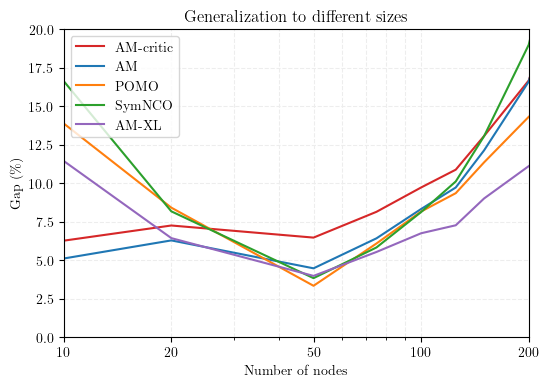

In [54]:

fig, ax = plt.subplots(figsize=(6,4))

data_generalization = defaultdict(list)

for experiment in experiments:
    # add data to save and plot
    stats = experiments[experiment]
    data_generalization[experiment] = stats

    ax.plot(stats['num_nodes'], stats['optimality_gap'], label=labels[experiment], color=colors[experiment])

# log scale
ax.set_xscale('log')
# ax.set_yscale('log')

# cut plot at 10 nodes
# ax.set_xlim([10, 1000])
ax.set_xlim([10, 200])

# replace x-axis ticks
# ax.set_xticks([10, 20, 50, 100, 200, 500, 1000])
ax.set_xticks([10, 20, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Set plot title
ax.set_title('Generalization to different sizes')

# Set x-axis label
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Gap (\%)')

ax.set_ylim([0, 20])
ax.set_ylim([0, None])

# Training size: draw vertical line at num_nodes = stats['num_nodes'][-1]
# ax.axvline(x=stats['num_nodes'][-1])#, color='tab:red', linestyle='--', linewidth=1)

# Set grid on with dashed lines for log scale
ax.grid(True, which="both", ls="--", color='0.93')

# legend
ax.legend(loc='upper left')

# Save plot data
save_folder = Path('plots/')
save_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(save_folder / f'{exp_name}.pdf', bbox_inches='tight')

# Save data with pickle
with open(save_folder / f'{exp_name}_data.pkl', 'wb') as f:
    pickle.dump(data_generalization, f)